     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
Detected encoding: utf-8
File is already in UTF-8 encoding.

Data types of category columns after conversion:
Sexual       int64
Violence     int64
Substance    int64
Language     int64
dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



Fold 1/5


pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.483400,0.451015,0.373874,0.757709,0.599303,0.669261
2,0.357500,0.336356,0.603604,0.910314,0.707317,0.796078
3,0.259700,0.259990,0.689189,0.943966,0.763066,0.843931
4,0.168100,0.167992,0.828829,0.976562,0.871080,0.920810
5,0.153100,0.134861,0.864865,0.960145,0.923345,0.941385
6,0.066900,0.112943,0.869369,0.970588,0.919861,0.944544
7,0.055200,0.101214,0.891892,0.971119,0.937282,0.953901
8,0.056800,0.098033,0.891892,0.971119,0.937282,0.953901



Fold 2/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.471000,0.476351,0.355856,0.795322,0.475524,0.595186
2,0.400600,0.389343,0.504505,0.926136,0.569930,0.705628
3,0.289900,0.259810,0.716216,0.948052,0.765734,0.847195
4,0.221800,0.197484,0.770270,0.978992,0.814685,0.889313
5,0.127400,0.145977,0.846847,0.965909,0.891608,0.927273
6,0.080300,0.115617,0.896396,0.964413,0.947552,0.955908
7,0.054200,0.107150,0.905405,0.978102,0.937063,0.957143
8,0.049000,0.103251,0.914414,0.978339,0.947552,0.962700



Fold 3/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.457700,0.456448,0.378378,0.728682,0.657343,0.691176
2,0.367200,0.375823,0.504505,0.899497,0.625874,0.738144
3,0.288800,0.279495,0.702703,0.960177,0.758741,0.847656
4,0.203500,0.221005,0.752252,0.962500,0.807692,0.878327
5,0.179100,0.193338,0.779279,0.942748,0.863636,0.901460
6,0.127900,0.162469,0.810811,0.947566,0.884615,0.915009
7,0.084000,0.142023,0.837838,0.955556,0.902098,0.928058
8,0.074000,0.134139,0.860360,0.953069,0.923077,0.937833



Fold 4/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.443600,0.449593,0.409910,0.785388,0.597222,0.678501
2,0.395100,0.356100,0.531532,0.892523,0.663194,0.760956
3,0.277300,0.247702,0.707207,0.901141,0.822917,0.860254
4,0.206400,0.200156,0.761261,0.925373,0.861111,0.892086
5,0.097900,0.160693,0.797297,0.940741,0.881944,0.910394
6,0.077300,0.129084,0.842342,0.949458,0.913194,0.930973
7,0.050600,0.118418,0.851351,0.946996,0.930556,0.938704
8,0.053600,0.113646,0.864865,0.954064,0.937500,0.945709



Fold 5/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.481900,0.497999,0.297297,0.830645,0.358885,0.501217
2,0.374500,0.393259,0.472973,0.878173,0.602787,0.714876
3,0.276800,0.286640,0.657658,0.966507,0.703833,0.814516
4,0.173000,0.235542,0.747748,0.953975,0.794425,0.866920
5,0.120900,0.180085,0.819820,0.957692,0.867596,0.910420
6,0.128200,0.156216,0.837838,0.941392,0.895470,0.917857
7,0.062400,0.151231,0.851351,0.959108,0.898955,0.928058
8,0.107300,0.148858,0.851351,0.952030,0.898955,0.924731



Test Set Metrics:
Accuracy: 0.9113
Precision: 0.9563
Recall: 0.9623
F1 Score: 0.9592
Accuracy for Sexual: 0.9516
Accuracy for Violence: 0.9758
Accuracy for Substance: 0.9758
Accuracy for Language: 0.9919

Overall Confusion Matrix:
[[330   7]
 [  6 153]]


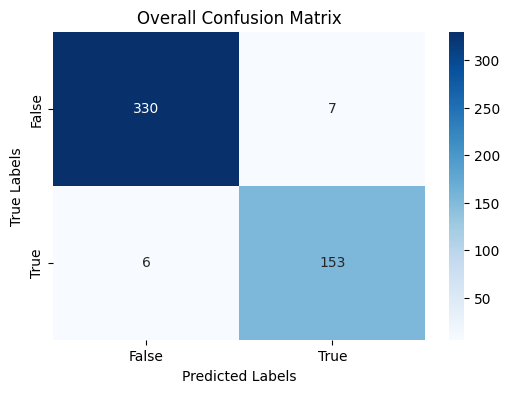

In [ ]:
!pip install --upgrade transformers

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from torch.utils.data import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import os
import chardet

# Disable W&B logging
os.environ["WANDB_MODE"] = "disabled"

# Detect file encoding
file_path = 'merged_labeled_all.csv'
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
encoding_type = result['encoding']
print('Detected encoding:', encoding_type)

# If encoding is not 'utf-8', convert the file to UTF-8
if encoding_type.lower() != 'utf-8':
    # Convert CSV file to UTF-8 encoding
    with open(file_path, 'r', encoding=encoding_type, errors='ignore') as f_in:
        content = f_in.read()
    utf8_file_path = 'merged_labeled_all_utf8.csv'
    with open(utf8_file_path, 'w', encoding='utf-8') as f_out:
        f_out.write(content)
    file_path = utf8_file_path  # Update file path to the new UTF-8 file
else:
    print("File is already in UTF-8 encoding.")

# Load dataset with UTF-8 encoding
data = pd.read_csv(file_path, encoding='utf-8')

# Map category columns from 'T'/'F' to 1/0 and convert to integer type
categories = ['Sexual', 'Violence', 'Substance', 'Language']
for category in categories:
    data[category] = data[category].map({'T': 1, 'F': 0}).astype(int)

# Verify data types of category columns
print("\nData types of category columns after conversion:")
print(data[categories].dtypes)

# Create a stratify column by combining labels into a string
data['stratify_col'] = data[categories].astype(str).agg(''.join, axis=1)

# Split data into train+val and test sets
train_val_data, test_data = train_test_split(
    data,
    test_size=0.1,
    stratify=data['stratify_col'],
    random_state=42
)
train_val_data = train_val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Initialize tokenizer
tokenizer = BigBirdTokenizer.from_pretrained("google/bigbird-roberta-base")

# Dataset class
class LyricsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=1024):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.categories = categories

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['lyrics']
        tokens = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        # Ensure labels are float tensors
        labels = torch.tensor(row[self.categories].values.astype(np.float32))
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'labels': labels
        }

# Metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (preds > 0.5).astype(int)
    labels = labels.astype(int)

    # Calculate subset accuracy
    subset_accuracy = accuracy_score(labels, preds)

    # Calculate overall precision, recall, F1-score
    overall_precision = precision_score(labels.flatten(), preds.flatten(), zero_division=0)
    overall_recall = recall_score(labels.flatten(), preds.flatten(), zero_division=0)
    overall_f1 = f1_score(labels.flatten(), preds.flatten(), zero_division=0)

    return {
        "accuracy": subset_accuracy,
        "precision": overall_precision,
        "recall": overall_recall,
        "f1": overall_f1
    }

# Set hyperparameters
num_epochs = 8
batch_size = 8
learning_rate = 2e-5

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    metric_for_best_model="f1",
    load_best_model_at_end=True
)

# Prepare for k-Fold Cross Validation on train+val set
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

# Assign fold numbers
train_val_data['fold'] = -1
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_val_data, train_val_data['stratify_col'])):
    train_val_data.loc[val_idx, 'fold'] = fold_idx

# Training and evaluating with k-fold
for fold in range(k):
    print(f"\nFold {fold + 1}/{k}")
    train_data = train_val_data[train_val_data['fold'] != fold]
    val_data = train_val_data[train_val_data['fold'] == fold]

    train_dataset = LyricsDataset(train_data, tokenizer)
    val_dataset = LyricsDataset(val_data, tokenizer)

    model = BigBirdForSequenceClassification.from_pretrained(
        "google/bigbird-roberta-base",
        num_labels=len(categories)
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics
    )

    trainer.train()

# Evaluate on test set
test_dataset = LyricsDataset(test_data, tokenizer)
trainer.model.eval()
test_predictions = trainer.predict(test_dataset)
test_pred_labels = (torch.sigmoid(torch.tensor(test_predictions.predictions)).numpy() > 0.5).astype(int)
test_true_labels = test_predictions.label_ids

# Calculate overall metrics
subset_accuracy = accuracy_score(test_true_labels, test_pred_labels)
overall_precision = precision_score(test_true_labels.flatten(), test_pred_labels.flatten(), zero_division=0)
overall_recall = recall_score(test_true_labels.flatten(), test_pred_labels.flatten(), zero_division=0)
overall_f1 = f1_score(test_true_labels.flatten(), test_pred_labels.flatten(), zero_division=0)

print("\nTest Set Metrics:")
print(f"Accuracy: {subset_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

# Calculate accuracy for each category
for idx, category in enumerate(categories):
    category_true = test_true_labels[:, idx]
    category_pred = test_pred_labels[:, idx]
    accuracy = accuracy_score(category_true, category_pred)
    print(f"Accuracy for {category}: {accuracy:.4f}")

# Compute overall confusion matrix
overall_true_labels = test_true_labels.flatten()
overall_pred_labels = test_pred_labels.flatten()
overall_conf_matrix = confusion_matrix(overall_true_labels, overall_pred_labels)

print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Visualize overall confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    overall_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['False', 'True'],
    yticklabels=['False', 'True']
)
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
